
# 🔄 Binary‑Recursion Quick Bench  
Optimised for **Colab free tier** (≤ 2 GB RAM, 1 CPU).  
Key speedups:

* Histogram only over **0 – 1e‑4** (where spikes live) at 1e‑7 bins → 1 000 bins instead of 10 M.  
* Vectorised NumPy generation, no Python loops in inner hot‑path.  
* KDE computed on a 200 k random subsample to avoid SciPy choking.


In [1]:

import numpy as np, matplotlib.pyplot as plt
from mpmath import mp
from scipy.stats import gaussian_kde

mp.dps = 50
alpha_inv = mp.mpf('137.035999084')
alpha = 1/alpha_inv


In [2]:

def binary_squared_values_vec(max_len, cutoff=1e-4):
    """Return np.array of squared binary‑string values <= cutoff."""
    out = []
    for n in range(1, max_len+1):
        denom = 1<<n
        arr = np.arange(denom, dtype=np.float64)/denom
        sq = arr*arr
        out.append(sq[sq<=cutoff])
    return np.concatenate(out)


In [3]:

def focused_hist(data, cutoff=1e-4, bin_width=1e-7):
    bins = np.arange(0, cutoff+bin_width, bin_width)
    counts, edges = np.histogram(data, bins=bins)
    idx = counts.argmax()
    peak_x = 0.5*(edges[idx]+edges[idx+1])
    peak_h = counts[idx]
    return peak_x, peak_h, edges[:-1], counts


Collected 167785 values <=1e-4
Histogram peak @ 5.000000000e-08  height=5321
KDE peak @       6.841368274e-06


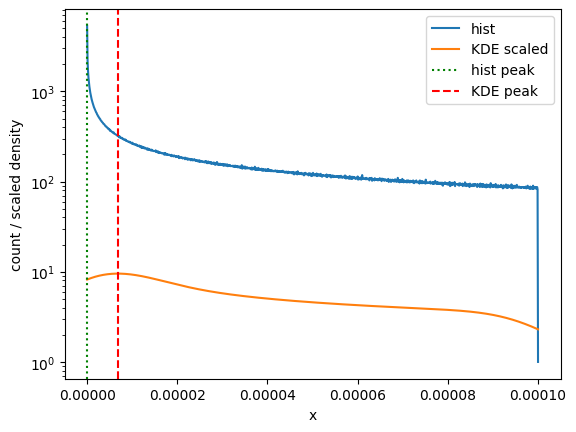

In [4]:

MAX_LEN = 23
vals = binary_squared_values_vec(MAX_LEN)
print("Collected", len(vals), "values <=1e-4")

peak_x, peak_h, xs, cs = focused_hist(vals)
print(f"Histogram peak @ {peak_x:.9e}  height={peak_h}")

# KDE on subsample
sample = np.random.choice(vals, size=min(200_000, len(vals)), replace=False)
kde = gaussian_kde(sample, bw_method=0.3)
dense_x = np.linspace(0, 1e-4, 5000)
dense_y = kde(dense_x)
kpx = dense_x[dense_y.argmax()]
print(f"KDE peak @       {kpx:.9e}")

plt.semilogy(xs, cs+1, label='hist')
plt.semilogy(dense_x, dense_y*dense_x.size*1e-7 + 1, label='KDE scaled')
plt.axvline(peak_x, color='g', ls=':', label='hist peak')
plt.axvline(kpx, color='r', ls='--', label='KDE peak')
plt.xlabel('x'); plt.ylabel('count / scaled density'); plt.legend()
plt.show()


In [5]:

grid = np.array([k*alpha/mp.pi for k in range(1,100)], dtype=float)
dist = np.min(np.abs(grid - kpx))
print("Distance of KDE peak to α/π grid:", dist)


Distance of KDE peak to α/π grid: 0.0023159780974980645
